In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm 
import sklearn.metrics as skm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
df = pd.read_csv("data.csv")
df = df.drop(['Unnamed: 0','Unnamed: 10'], axis=1)
df = df.dropna()
df = df[df['period']>=1996]
df.head()

,period,sectorId,sector-name,fuelId,fuel-name,stateId,state-name,value,value-units,region,population,value-population
0,2021,RC,Residential carbon dioxide emissions,CO,Coal,SC,South Carolina,0.000000,million metric tons of CO2,SERC,5193,population in thousands
1,2021,TT,Total carbon dioxide emissions from all sectors,NG,Natural Gas,DC,District of Columbia,1.499258,million metric tons of CO2,RFC,669,population in thousands
2,2021,TT,Total carbon dioxide emissions from all sectors,PE,Petroleum,DC,District of Columbia,1.021598,million metric tons of CO2,RFC,669,population in thousands
3,2021,TT,Total carbon dioxide emissions from all sectors,CO,Coal,DC,District of Columbia,0.000000,million metric tons of CO2,RFC,669,population in thousands
4,2021,TT,Total carbon dioxide emissions from all sectors,TO,All Fuels,DC,District of Columbia,2.520856,million metric tons of CO2,RFC,669,population in thousands


In [3]:
#filtering data for total United States, Alaska and Hawaii. Build dataset only for Total carbon dioxide emissions from all sectors
mask = df['state-name'].isin(['United States', 'Alaska', 'Hawaii'])
filter_df = df[~mask]
filter_df = filter_df[(filter_df['sectorId'] == 'TT') & (filter_df['fuelId'] != 'TO')].sort_values(['period'])
filter_df.head()


,period,sectorId,sector-name,fuelId,fuel-name,stateId,state-name,value,value-units,region,population,value-population
32447,1996,TT,Total carbon dioxide emissions from all sectors,NG,Natural Gas,TN,Tennessee,15.048713,million metric tons of CO2,SERC,5417,population in thousands
31659,1996,TT,Total carbon dioxide emissions from all sectors,NG,Natural Gas,NY,New York,64.783701,million metric tons of CO2,NPCC,18588,population in thousands
31637,1996,TT,Total carbon dioxide emissions from all sectors,CO,Coal,MO,Missouri,59.963110,million metric tons of CO2,SERC,5432,population in thousands
31636,1996,TT,Total carbon dioxide emissions from all sectors,PE,Petroleum,MO,Missouri,46.898234,million metric tons of CO2,SERC,5432,population in thousands
31614,1996,TT,Total carbon dioxide emissions from all sectors,CO,Coal,NE,Nebraska,16.997587,million metric tons of CO2,MRO,1674,population in thousands


In [4]:
def data_exploration_plot(df):
    plt.figure(figsize=(20,10))
    sns.set_style("whitegrid")
    for s, d in df.groupby('region'):
        plt.plot(d['period'],d['value'], label = s)
    plt.legend()
    plt.title('Total CO2 emission for United States by region')
    plt.ylabel('CO2 in million metric tons')
    plt.xlabel('Year')
    plt.show()

In [5]:
def ARIMA_train(df,p,d,q):
    model = ARIMA(df, order = (p,d,q)).fit()
    return model

In [6]:
evaluation_df = pd.DataFrame(index=['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_square_error', 'r2_score'])
def evaluation_metric(df, forecast):
    mae = skm.mean_absolute_error(df,forecast)
    mape = skm.mean_absolute_percentage_error(df,forecast)
    rmse = np.sqrt(skm.mean_squared_error(df,forecast))
    r2 = skm.r2_score(df, forecast)
    return [mae,mape,rmse,r2]

In [7]:
def models_with_evaluation(df, region): 
    #plot time series graph
    #data_exploration_plot(df)
    df_train = df[(df['period']<= 2012)]
    df_test = df[df['period']>2012]
    values = df_train['value']
    values_test = df_test['value']
    #plotting acf graph 
    plot_acf(values)
    #plotting pacf graph
    plot_pacf(values)
    #Training ARIMA(1,0,0) i.e Autoregressor model 
    model1 = ARIMA_train(values, 1,0,0)
    evaluation_df['ARIMA(1,0,0)_'+ region] = evaluation_metric(values_test,model1.forecast(len(values_test)))
    #print("Summary of ARIMA(1,0,0)")
    #print(model1.summary())
    #Training ARIMA(0,0,4) i.e.Moving Average model 
    model2 = ARIMA_train(values,0,0,2)
    evaluation_df['ARIMA(0,0,2)_'+ region] = evaluation_metric(values_test,model2.forecast(len(values_test)))
    #print("Summary of ARIMA(0,0,2)")
    #print(model2.summary())
    #Training Auto ARIMA 
    model3 = pm.auto_arima(values, stepwise = False, seasonal = False)
    model_selected = model3.get_params()['order']
    model_string = "(" + ", ".join(map(str, model_selected)) + ")"
    evaluation_df['ARIMA'+model_string+'_'+region] = evaluation_metric(values_test,model3.predict(n_periods =len(values_test)))
    #print("Summary of Auto-ARIMA model")
    #print(model3.summary())
    model4 = SimpleExpSmoothing(values)
    evaluation_df['ES_level_none_'+region] = evaluation_metric(values_test, model4.fit().forecast(len(values_test)))
    evaluation_df['ES_level_0.2_'+region] = evaluation_metric(values_test, model4.fit(smoothing_level=.2).forecast(len(values_test)))
    evaluation_df['ES_level_0.5_'+region] = evaluation_metric(values_test, model4.fit(smoothing_level=.5).forecast(len(values_test)))
    
    

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

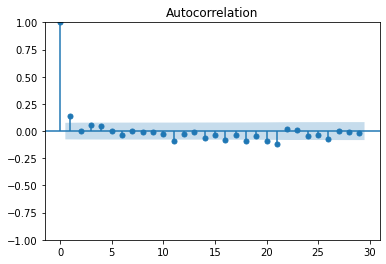

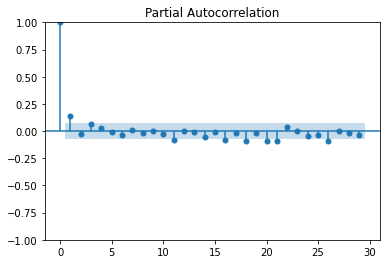

In [8]:
# Result for region SERC
df_serc = filter_df[(filter_df['region']=='SERC')]
models_with_evaluation(df_serc, 'SERC')

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

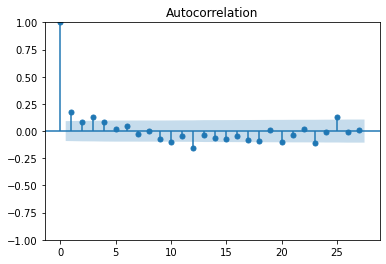

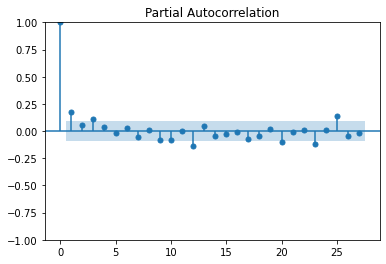

In [9]:
# Result for region RFC
df_rfc = filter_df[(filter_df['region']=='RFC')]
models_with_evaluation(df_rfc, 'RFC')

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

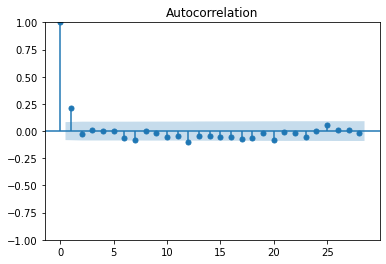

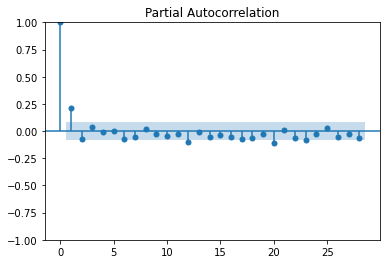

In [10]:
# Result for region WECC
df_wecc = filter_df[(filter_df['region']=='WECC')]
models_with_evaluation(df_wecc, 'WECC')

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

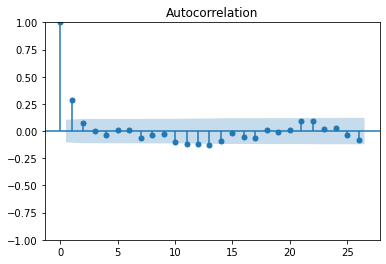

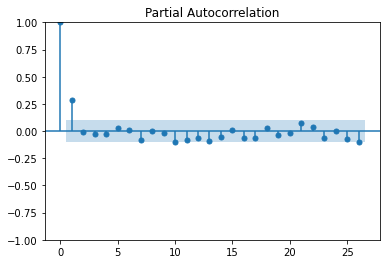

In [11]:
# Result for region NPCC
df_npcc = filter_df[(filter_df['region']=='NPCC')]
models_with_evaluation(df_npcc, 'NPCC')

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

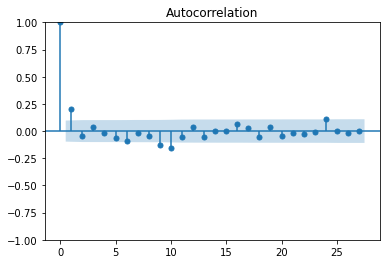

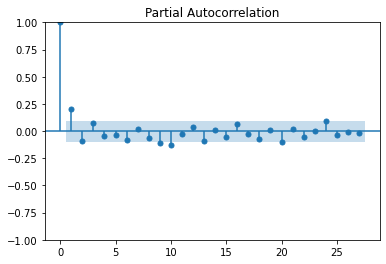

In [12]:
# Result for region MRO
df_mro = filter_df[(filter_df['region']=='MRO')]
models_with_evaluation(df_mro, 'MRO')

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_m

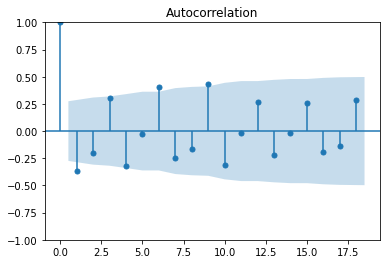

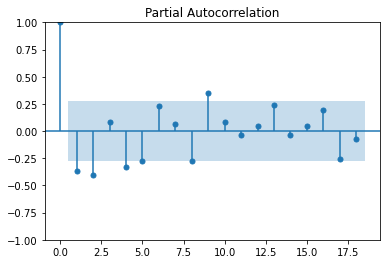

In [13]:
# Result for region TX
df_tx = filter_df[(filter_df['region']=='TX')]
models_with_evaluation(df_tx, 'TX')

In [14]:
evaluation_df.to_excel("evaluation.xlsx")

In [ ]:
def models_with_evaluation(df, region): 
    #plot time series graph
    #data_exploration_plot(df)
    df_train = df[(df['period']<= 2012)]
    df_test = df[df['period']>2012]
    values = df_train['value']
    values_test = df_test['value']
    #plotting acf graph 
    plot_acf(values)
    #plotting pacf graph
    plot_pacf(values)
    #Training ARIMA(1,0,0) i.e Autoregressor model 
    model1 = ARIMA_train(values, 1,0,0)
    evaluation_df['ARIMA(1,0,0)_'+ region] = evaluation_metric(values_test,model1.forecast(len(values_test)))
    #print("Summary of ARIMA(1,0,0)")
    #print(model1.summary())
    #Training ARIMA(0,0,4) i.e.Moving Average model 
    model2 = ARIMA_train(values,0,0,2)
    evaluation_df['ARIMA(0,0,2)_'+ region] = evaluation_metric(values_test,model2.forecast(len(values_test)))
    #print("Summary of ARIMA(0,0,2)")
    #print(model2.summary())
    #Training Auto ARIMA 
    model3 = pm.auto_arima(values, stepwise = False, seasonal = False)
    model_selected = model3.get_params()['order']
    model_string = "(" + ", ".join(map(str, model_selected)) + ")"
    evaluation_df['ARIMA'+model_string+'_'+region] = evaluation_metric(values_test,model3.predict(n_periods =len(values_test)))
    #print("Summary of Auto-ARIMA model")
    #print(model3.summary())
    model4 = SimpleExpSmoothing(values)
    evaluation_df['ES_level_none_'+region] = evaluation_metric(values_test, model4.fit().forecast(len(values_test)))
    evaluation_df['ES_level_0.2_'+region] = evaluation_metric(values_test, model4.fit(smoothing_level=.2).forecast(len(values_test)))
    evaluation_df['ES_level_0.5_'+region] = evaluation_metric(values_test, model4.fit(smoothing_level=.5).forecast(len(values_test)))
    

In [25]:
#SERC model selected 
result_serc = SimpleExpSmoothing(df_serc[df_serc['period']<=2012]['value']).fit(smoothing_level=.2).forecast(len(df_serc[df_serc['period']>2012]['value']))
df_serc['ES_level_0.2_SERC'] = [None]*len(df_serc[df_serc['period']<=2012]['value']) + result_serc.to_list()
#df_serc.to_csv("SERC.csv")

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\2774544259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_serc['ES_level_0.2_SERC'] = [None]*len(df_serc[df_serc['period']<=2012]['value']) + result_serc.to_list()


In [29]:
# RFC model selected 
model_rfc = ARIMA_train(df_rfc[df_rfc['period']<=2012]['value'],0,0,2)
result_rfc = model_rfc.forecast(len(df_rfc[df_rfc['period']>2012]['value']))
df_rfc['ARIMA(0,0,2)_RFC'] =  [None]*len(df_rfc[df_rfc['period']<=2012]['value']) + result_rfc.to_list()
#df_rfc.tail(15)

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\3354727246.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [33]:
#WECC model selection 
result_wecc = SimpleExpSmoothing(df_wecc[df_wecc['period']<=2012]['value']).fit(smoothing_level=.5).forecast(len(df_wecc[df_wecc['period']>2012]['value']))
df_wecc['ES_level_0.5_WECC'] = [None]*len(df_wecc[df_wecc['period']<=2012]['value']) + result_wecc.to_list()
#df_wecc.head()

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\2517048517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wecc['ES_level_0.5_WECC'] = [None]*len(df_wecc[df_wecc['period']<=2012]['value']) + result_wecc.to_list()


In [34]:
#NPCC model selection 
model_npcc = ARIMA_train(df_npcc[df_npcc['period']<=2012]['value'],1,0,1)
result_npcc = model_npcc.forecast(len(df_npcc[df_npcc['period']>2012]['value']))
df_npcc['ARIMA(1,0,1)_NPCC'] =  [None]*len(df_npcc[df_npcc['period']<=2012]['value']) + result_npcc.to_list()
#df_npcc.head()

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\1448210418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [37]:
#MRO model selection 
result_mro = SimpleExpSmoothing(df_mro[df_mro['period']<=2012]['value']).fit().forecast(len(df_mro[df_mro['period']>2012]['value']))
df_mro['ES_level_none_MRO'] = [None]*len(df_mro[df_mro['period']<=2012]['value']) + result_mro.to_list()


C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\2546787960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mro['ES_level_none_MRO'] = [None]*len(df_mro[df_mro['period']<=2012]['value']) + result_mro.to_list()


In [39]:
# TX model selected 
model_tx = ARIMA_train(df_tx[df_tx['period']<=2012]['value'],0,0,2)
result_tx = model_tx.forecast(len(df_tx[df_tx['period']>2012]['value']))
df_tx['ARIMA(0,0,2)_TX'] =  [None]*len(df_tx[df_tx['period']<=2012]['value']) + result_tx.to_list()

C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\sharv\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\1365576203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [49]:
df_output = df_serc.append(df_rfc)
df_output = df_output.append(df_wecc)
df_output = df_output.append(df_npcc)
df_output = df_output.append(df_mro)
df_output = df_output.append(df_tx)
df_output.to_csv('output.csv')

C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\3980524072.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_serc.append(df_rfc)
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\3980524072.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_wecc)
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\3980524072.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_npcc)
C:\Users\sharv\AppData\Local\Temp\ipykernel_16580\3980524072.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(df_mro)
C:\Users\sharv\AppData\Local\Temp\ipykernel_